## Chain size
The goal of this notebook is to examine how many samples are needed for the normalizing flow result to converge and to get a good estimate of the evidence. 

There is a chain (godzilla.h5) with 120 walkers and 200000 samples per walker for a total of 24000000 samples. The analysis will be done by decreasing the thinning parameter of the chain and repeating the calculations.

In [3]:
import numpy as np

import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib inline

In [4]:
### open the long chain
filename = "/home/grads/ownCloud/StatisticalProject/chains/godzilla.h5"
reader = emcee.backends.HDFBackend(filename, read_only=True)

#all samples
samples = reader.get_chain(flat=True)
#print(len(samples))
#remove burn in and thin
samples_thin = reader.get_chain(flat=True, thin=1000, discard=5000)

In [5]:
### open the planck 3x2 chain in getdist
path = '/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE'
planck = getdist.mcsamples.loadMCSamples(file_root=path, no_cache=True)

/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_3.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_4.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_2.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_1.txt
Removed no burn in


['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2', 'calPlanck']
['omegabh2', 'omegach2', 'logA', 'ns']
[3, 4, 0, 1]
[0, 1, 4, 5]
[[0.02694912 0.12613896 3.04702737 0.95946097]
 [0.01868599 0.11163032 3.09469627 0.96810195]
 [0.01984142 0.11038238 3.0987001  1.00382673]
 ...
 [0.02076785 0.10857063 3.16067819 0.99915605]
 [0.03411209 0.13943478 3.01789088 0.95785104]
 [0.02250137 0.11744414 3.06321669 0.97490995]]
[[0.02251422 0.1181112  3.150362   0.9719029 ]
 [0.02247766 0.1174938  3.099883   0.9694963 ]
 [0.02243321 0.118116   3.08672    0.9683467 ]
 ...
 [0.02255978 0.1193333  3.088315   0.9696493 ]
 [0.0226116  0.1190064  3.119385   0.9713015 ]
 [0.02258974 0.1192308  3.135369   0.9710297 ]]
Removed no burn in

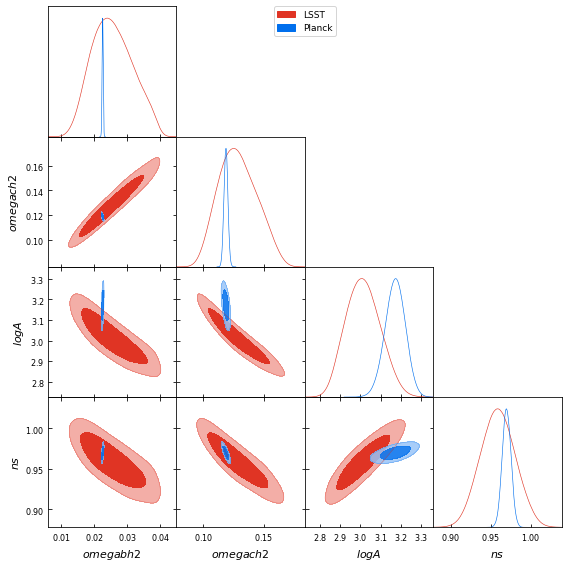

In [6]:
### sanity check 
samples_names = ['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
planck_names = planck.getParamNames().getRunningNames()
print(samples_names)
print(planck_names)
# get parameters only in both chains
common_params = [param for param in planck_names if param in samples_names]
print(common_params)
idx_1 = [samples_names.index(param) for param in common_params]
idx_2 = [planck_names.index(param) for param in common_params]
print(idx_1)
print(idx_2)
# get the data for common params
common_samples = samples_thin[...,idx_1]
common_planck  = planck.samples[...,idx_2]
print(common_samples)
print(common_planck)
samples_chain_common = MCSamples(samples=common_samples,names=common_params,labels=common_params,label='LSST')
planck_chain_common = MCSamples(samples=common_planck,names=common_params,labels=common_params,label='Planck')
g = plots.get_subplot_plotter()
g.triangle_plot([samples_chain_common,planck_chain_common], filled=True, params=common_params)
#g = plots.get_subplot_plotter()
#g.triangle_plot([planck_chain_common], filled=True, params=common_params)

In [10]:
# create an array of chain lengths:
samples = reader.get_chain(flat=True, thin=1, discard=5000)
print(len(samples))
#chain_lengths = np.arange(100,10000,10000)
chain_lengths = [100,500,1000,5000,10000,20000,40000,60000,80000,100000,150000,200000,250000]#,500000,1000000,5000000,10000000,20000000]
#chain_lengths = np.concatenate((chain_lengths,np.array([len(samples)])))
print(len(chain_lengths))

23400000
13


In [8]:
# These are the functions needed for the flow
class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!',end="")
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)
        
class No_Plot_Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!',end="")

def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector
    
    new_data = bijector.inverse(data.astype(np.float32))

    # now map the data
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs,feedback=True):
    #covmat = data.cov().astype(np.float32)
    #mean = data.getMeans().astype(np.float32)

    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    #print(_data)
    xdata = np.stack(_data, axis=-1)
    #print(xdata)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    if(feedback):
        print('---   Model compiled   ---')
        print(" - N samples = {}".format(nsamples))
        if weights.all()==weights[0]:
            print(" - Uniform weights = {}".format(weights[0]))
        else:
            print(" - Non-uniform weights")
        print(" - Pre-Gaussian Map = True\n")
        print(" - Validation split = {}".format(val_split))
        print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
        print(' - Trainable parameters = {} \n'.format(model.count_params()))

    # now perform the fit
    if(feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    if(not feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[No_Plot_Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
        
    return(target_distribution,bij)

def setup(n_maf,n_params,permute,feedback=True):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    if(feedback):
        print('---   MADE Info   ---')
        print(' - Hidden_units = {}'.format(hidden_units))
        print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

def diff_boost(n_boost,chains):
    ### In this notebook, the first sample is variable length and the second is planck
    #   We want to use only the number of samples that are in the variable length
    #   So the code to comput the difference is slightly changed from the final implementation
    
    # get data
    chain1 = chains[0].samples
    chain2 = chains[1].samples
    w_chain1 = chains[0].weights
    w_chain2 = chains[1].weights
    ll_chain1 = chains[0].loglikes
    ll_chain2 = chains[1].loglikes
    
    samples_names = chains[0].getParamNames().getRunningNames()
    planck_names = chains[1].getParamNames().getRunningNames()
    common_params = [param for param in planck_names if param in samples_names]
    
    idx1 = [samples_names.index(param) for param in common_params]
    idx2 = [planck_names.index(param) for param in common_params]
    assert len(idx1)==len(idx2)
    # get the data for common params
    common_samples = samples[...,idx1]
    common_planck  = planck.samples[...,idx2]
    
    # ensure first chain is longer than the second.
    # Need to keep track if I flipped the data so I get the signs right (although in principle it doesn't matter, Its better for everyones results to look the same even if they import chains in different orders)
    flip=False
    if( len(chain1) < len(chain2) ):
        #chain1,chain2 = chain2,chain1
        #w_chain1,w_chain2 = w_chain2,w_chain1
        #ll_chain1,ll_chain2 = ll_chain2,ll_chain1
        #idx1,idx2 = idx2,idx1
        flip=True
    
    N1 = len(chain1)
    N2 = len(chain2)
    #print('N1 = {}'.format(N1))
    #print('N2 = {}'.format(N2))
    
    # set up parameter diff arrays
    diff = np.zeros((N1*n_boost,len(idx1)),dtype=np.float32)
    weights = np.zeros(N1*n_boost,dtype=np.float32)
    loglikes = np.zeros(N1*n_boost,dtype=np.float32)
        
    for i in range(n_boost):
        # find the range of indices to use for chain 2
        lower = int((i/n_boost)*N1)
        upper = lower+N1

        # compute stuff
        if flip==True:
            #diff[i*N1:(i+1)*N1] = -chain1[:N1,idx1] + np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - chain2[:N1,idx2]
            weights[i*N1:(i+1)*N1] = w_chain1 * w_chain2[:N1]
        else:
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
            weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        #weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        #if(ll_chain1 is not None and ll_chain2 is not None):
        #    loglikes[i*N1:(i+1)*N1] = ll_chain1+np.take(ll_chain2, range(lower,upper), mode='wrap')
    
    min_weight_ratio = min(chains[0].min_weight_ratio,
                               chains[1].min_weight_ratio)

    diff_samples = WeightedSamples(ignore_rows=0,
                                   samples=diff,
                                   weights=weights, loglikes=loglikes,
                                   name_tag=' ', label=' ',
                                   min_weight_ratio=min_weight_ratio)

    return diff_samples
    
def significance(trained_dist,bijector,nparams,alpha=0.32):
    # The alpha is used for beta function for the confidence. Raveri et. al. defaults to 0.32
    prob = trained_dist.prob(bijector.inverse(np.zeros(nparams,dtype=np.float32)))
    n_points = 10000
    n_pass = 0

    _s = trained_dist.sample(n_points)
    _v = trained_dist.prob(_s)
    for val in _v:
        if val>prob:
            n_pass+=1
    # use clopper-pearson to find confidence level
    low = scipy.stats.beta.ppf(alpha/2,float(n_pass),float(n_points-n_pass+1))
    high = scipy.stats.beta.ppf(1-alpha/2,float(n_pass+1),float(n_points-n_pass))

    # compute sigma based on gaussian
    n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
    sigma_high = np.sqrt(2)*scipy.special.erfinv(high)
    sigma_low = np.sqrt(2)*scipy.special.erfinv(low)
    
    return n_sigma,sigma_high,sigma_low

In [83]:
# Now we want to do the NF for each chain length.

n_runs = 25 # the NF will be done n_runs times for each chain length. The uncertainty is computed from the variance of the results

N = np.zeros(len(chain_lengths))
n_sigma = np.zeros((len(chain_lengths),2))
for i in range(len(chain_lengths)):
    run = 0
    sigmas = np.zeros(n_runs)
    l = chain_lengths[i]
    print(l)
    while run < n_runs:
        #idxs = np.random.choice(len(samples),size=l)
        #print(idxs)
        s = samples[:l,...]
        s = samples[idxs,...]
        #print(s)
        
        #s = reader.get_chain(flat=True, thin=10000, discard=5000)
        #print(len(s))
        samples_chain = MCSamples(samples=s[...,:5],names=samples_names,labels=samples_names)
        diff = [diff_boost(1,[samples_chain,planck])]
        param_diff_chain = getdist.MCSamples(names=common_params,labels=common_params)
        param_diff_chain.chains = diff
        param_diff_chain.makeSingle()

        n_params = len(param_diff_chain.getParamNames().list())
        dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

        bijectors = setup(2*n_params,n_params,True,feedback=False)
        
        batch=100
        if l<1000:
            batch=10

        trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=int(l/batch),n_epochs=50,feedback=False)
        sigma,high,low = significance(trained_dist,bijector,n_params)
        sigmas[run] = sigma
        #print(sigma)
        
        run+=1
        
    N[i] = l
    n_sigma[i,0] = np.mean(sigmas)
    n_sigma[i,1] = np.std(sigmas)
    
print(n_sigma)
print(N)


#param_diff_chain = getdist.MCSamples(names=common_params,labels=common_params)
#param_diff_chain.chains = diff
#param_diff_chain.makeSingle()
#g = plots.get_subplot_plotter()
#g.triangle_plot(param_diff_chain, params=common_params, filled=True)

100
Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)500
Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)1000
Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)Removed no burn in


[####################] Completed!. (epoch 49/50)5000
Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed no burn in
[####################] Completed!. (epoch 49/50)Removed n

KeyboardInterrupt: 

In [ ]:
#sample = MCSamples(samples=_samples.numpy(), names=common_params,label='learned dist')
#param_diff_chain = MCSamples(samples=param_diff,names=common_params,label='true dist')
#g = getdist.plots.get_subplot_plotter()
#g.settings.num_plot_contours = 2
#g.triangle_plot([param_diff_chain,sample],
#                params=common_params,
#                filled=False)

In [ ]:
nsigma_data = []
for i in range(len(N)):
    nsigma_data.append([N[i],n_sigma[i,0],n_sigma[i,1]])
print(nsigma_data)
np.savetxt('n_sigma_v_N.txt',nsigma_data)

In [ ]:
#data = np.array(nsigma_data)
#plt.errorbar(data[...,0],data[...,1],yerr=data[...,2],lw=0,elinewidth=2,marker='o')
#
#ax = plt.gca()
#ax.set_ylim([0, 2])

100
[100.           1.44841866   1.2366959    1.95401029   1.30703743
   1.51805712   2.14067817   1.77802347   1.33279222   1.63332815
   2.29557838   1.37220381   1.53493417   1.72238389   1.3884502
   1.58265553   1.62341837   1.47170706   1.42901473   1.73862924
   1.99815369   1.71361204   1.57828565   2.0673626    1.30117079
   1.31890762]
500
[500.           1.08708329   1.07829977   1.13709159   1.03087381
   1.12923195   1.19317715   1.15278169   1.37639298   1.04288836
   1.0850489    1.2001013    1.15595393   1.14453942   1.09984422
   1.15278169   1.11185616   1.22972527   1.15010652   1.14381589
   1.15010652   1.04656554   1.16011988   1.14962101   1.14986373
   1.09162037]
1000
[1.00000000e+03 8.54731153e-01 9.16890543e-01 1.02217094e+00
 9.60308447e-01 8.78449190e-01 9.49433852e-01 8.73482758e-01
 1.12403071e+00 9.95280210e-01 7.78965564e-01 9.78554804e-01
 9.20713550e-01 8.29714891e-01 9.87699172e-01 9.45507194e-01
 9.60706027e-01 9.07958780e-01 8.75135837e-01 8.534676

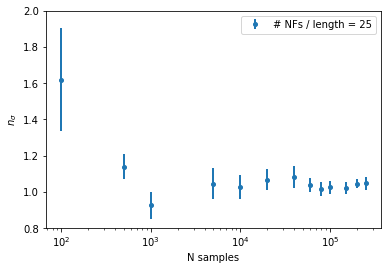

In [25]:
# Read from the file
x = []
y = []
e = []

for i in range(len(chain_lengths)):
    l = chain_lengths[i]
    print(l)
    _d = np.loadtxt('sigmavN'+str(l)+'.txt')
    print(_d)
    x.append(_d[0])
    sigmas = _d[1:]
    y.append(np.mean(sigmas))
    e.append(np.std(sigmas))
    
    
plt.errorbar(x,y,yerr=e,lw=0,elinewidth=2,marker='o',markersize=4,label='# NFs / length = 25')

ax = plt.gca()
ax.set_ylim([0.8, 2.0])
ax.legend()
plt.xlabel('N samples')
plt.ylabel('$n_\sigma$')
plt.xscale('log')